In [90]:
import numpy as np
import pandas as pd

import zipfile

from theano import tensor

import fuel
import h5py
from fuel.datasets.hdf5 import H5PYDataset
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme

from blocks.bricks import Linear, Softmax
from blocks.bricks.lookup import LookupTable
from blocks.bricks.cost import CategoricalCrossEntropy
from blocks.initialization import IsotropicGaussian, Constant

from blocks.filter import VariableFilter
from blocks.roles import WEIGHT
from blocks.graph import ComputationGraph

from blocks.main_loop import MainLoop
from blocks.algorithms import GradientDescent, AdaGrad

from blocks.extensions import FinishAfter, Printing, ProgressBar
from blocks.extensions.monitoring import TrainingDataMonitoring
from blocks_extras.extensions.plot import Plot

%matplotlib inline

In [60]:
from blocks.extensions import SimpleExtension

class SaveWeights(SimpleExtension):
    def __init__(self, layers, prefixes, **kwargs):
        kwargs.setdefault("after_epoch", True)
        super(SaveWeights, self).__init__(**kwargs)
        self.step = 1
        self.layers = layers
        self.prefixes = prefixes

    def do(self, callback_name, *args):
        for i in xrange(len(self.layers)):
            filename = "%s_%d.npy" % (self.prefixes[i], self.step)
            np.save(filename, self.layers[i].get_value())
        self.step += 1

In [19]:
filename = "./data/text8.zip"

def read_data(filename):
  f = zipfile.ZipFile(filename)
  for name in f.namelist():
    return f.read(name).split()
  f.close()
  
#words = read_data(filename)
#print 'Data size', len(words)

In [50]:
from fuel.datasets.base import Dataset

class WordWindow(Dataset):
    def __init__(self, **kwargs):
        self.provides_sources = ('features', 'targets')
         # for technical reasons
        self.axis_labels = None
        with self.open() as fh:
            self.corpus = fh.read().split()
        #print self.corpus 
        self.vocabulary_size = len(set(self.corpus))
        self.vocabulary = pd.factorize(self.corpus)
        self.num_instances = len([((self.vocabulary[0][i],self.vocabulary[0][i+2]),self.vocabulary[0][i+1]) for i in xrange(len(self.corpus)-2)])
        super(WordWindow, self).__init__(**kwargs)
    
    def get_data(self, state=None, request=None):
        data = [((self.vocabulary[0][i],self.vocabulary[0][i+2]),self.vocabulary[0][i+1]) for i in xrange(len(self.corpus)-2)]
        x, y = zip(*data)
        return np.array(x, dtype=np.int32), np.array(y, dtype=np.int32)

    def open(self):
        return open('./data/small')
    
    def close(self,fh):
        fh.close()
    
dataset = WordWindow()
print dataset.vocabulary_size
print dataset.vocabulary

7
(array([0, 1, 2, 0, 3, 0, 3, 2, 0, 1, 0, 4, 5, 0, 1, 0, 3, 5, 0, 4, 0, 4, 6,
       0, 1, 0, 4, 6, 0, 3]), array(['the', 'king', 'loves', 'queen', 'dwarf', 'hates', 'poisons'], dtype=object))


In [51]:
dataset.get_data()

(array([[0, 2],
        [1, 0],
        [2, 3],
        [0, 0],
        [3, 3],
        [0, 2],
        [3, 0],
        [2, 1],
        [0, 0],
        [1, 4],
        [0, 5],
        [4, 0],
        [5, 1],
        [0, 0],
        [1, 3],
        [0, 5],
        [3, 0],
        [5, 4],
        [0, 0],
        [4, 4],
        [0, 6],
        [4, 0],
        [6, 1],
        [0, 0],
        [1, 4],
        [0, 6],
        [4, 0],
        [6, 3]], dtype=int32),
 array([1, 2, 0, 3, 0, 3, 2, 0, 1, 0, 4, 5, 0, 1, 0, 3, 5, 0, 4, 0, 4, 6, 0,
        1, 0, 4, 6, 0], dtype=int32))

In [75]:
VOCAB_DIM = dataset.vocabulary_size
EMBEDDING_DIM = min(5,VOCAB_DIM)
CONTEXT = 1

def makeGraph():
    Xs = tensor.lmatrix("features")
    y = tensor.ivector('targets')
        
    w1 = LookupTable(name="w1", length=VOCAB_DIM, dim=EMBEDDING_DIM)
    w2 = Linear(name='w2', input_dim=EMBEDDING_DIM, output_dim=VOCAB_DIM)

    hidden = tensor.mean(w1.apply(Xs), axis=1)
    y_hat = Softmax().apply(w2.apply(hidden))
    
    w1.weights_init = w2.weights_init = IsotropicGaussian(0.01)
    w1.biases_init = w2.biases_init = Constant(0)
    w1.initialize()
    w2.initialize()
    
    cost = CategoricalCrossEntropy().apply(y, y_hat)
    
    cg = ComputationGraph(cost)
    W1, W2 = VariableFilter(roles=[WEIGHT])(cg.variables)
    
    cost = cost + 0.005 * (W1 ** 2).sum() + 0.005 * (W2 ** 2).sum()
    cost.name = "loss"

    
    
    return cg,(W1,W2),cost

In [92]:
cg, (W1, W2), cost = makeGraph()
main = MainLoop(data_stream = DataStream(
                    dataset,
                    iteration_scheme=SequentialScheme(dataset.num_instances, batch_size=50)),
                algorithm = GradientDescent(
                    cost = cost, 
                    parameters = cg.parameters,
                    step_rule = AdaGrad()),
                extensions = [
                    ProgressBar(),
                    FinishAfter(after_n_epochs=10),
                    #Printing(),
                    TrainingDataMonitoring(variables=[cost], after_batch=True),
                    SaveWeights(layers=[W1, W2], prefixes=["./w1","./w2"]),
])

main.run()

Epoch 0, step 1 |                                       | Elapsed Time: 0:00:00
Epoch 1, step 1 |                                       | Elapsed Time: 0:00:00
Epoch 2, step 1 |                                       | Elapsed Time: 0:00:00
Epoch 3, step 1 |                                       | Elapsed Time: 0:00:00
Epoch 4, step 1 |                                       | Elapsed Time: 0:00:00
Epoch 5, step 1 |                                       | Elapsed Time: 0:00:00
Epoch 6, step 1 |                                       | Elapsed Time: 0:00:00
Epoch 7, step 1 |                                       | Elapsed Time: 0:00:00
Epoch 8, step 1 |                                       | Elapsed Time: 0:00:00
Epoch 9, step 1 |                                       | Elapsed Time: 0:00:00


In [93]:
#np.load("w1_1.npy")

In [94]:
#np.load("w1_2.npy")

In [95]:
word_vectors = (W1.get_value() + W2.get_value().T) / 2

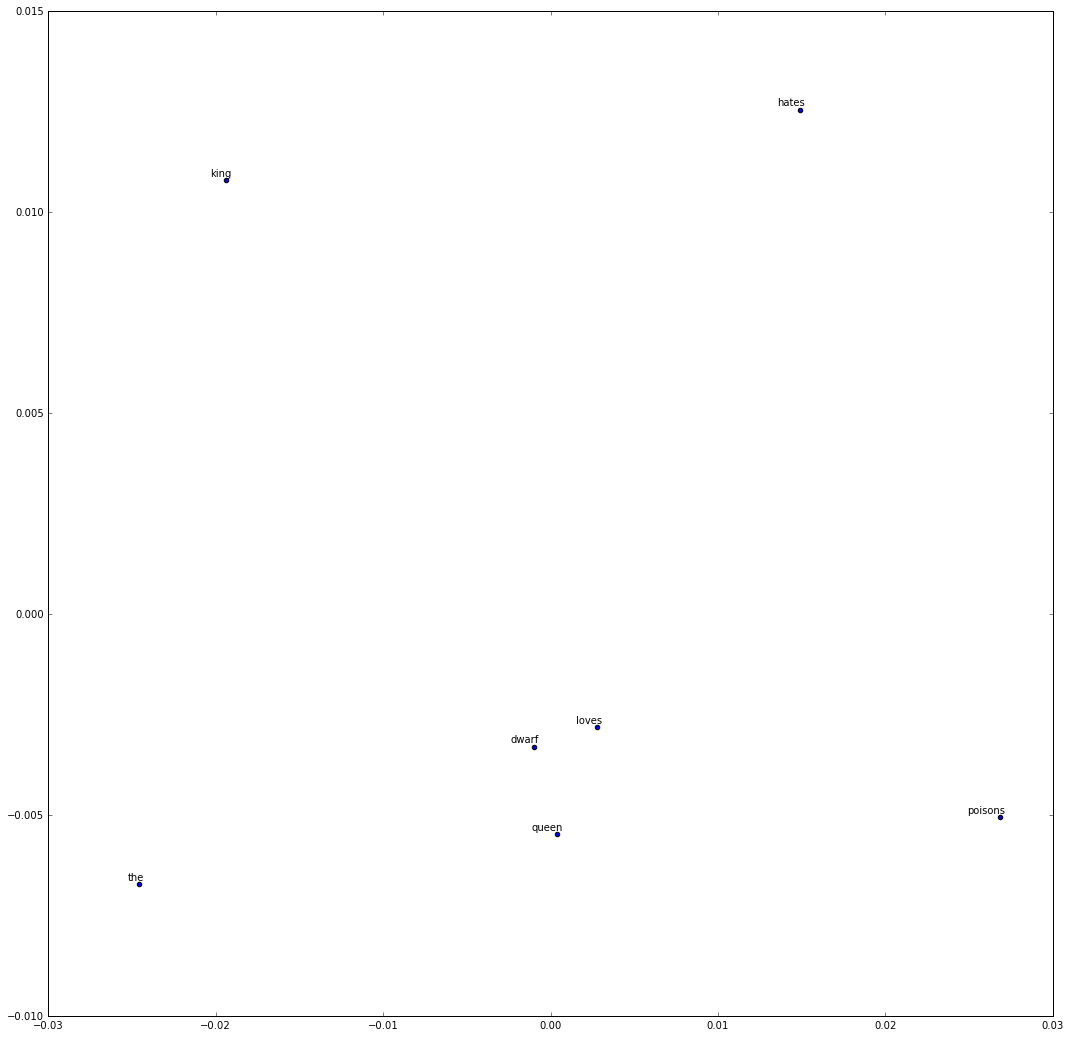

In [96]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
low_dim_embs = pca.fit_transform(word_vectors)

labels = dataset.vocabulary[1]

plt.figure(figsize=(18, 18))  #in inches
for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')